In [2]:
import numpy as np
from scipy.sparse.linalg import eigsh
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

## Задание 7 
# Задача рассеяния
## Параметры сетки и функции
Здесь задаются все требуемые при расчете параметры и функции.

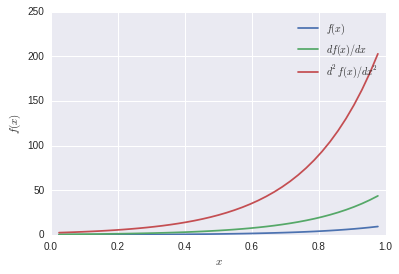

In [51]:
# равномерная сетка x \in [0,1] n=1,2,...N, N+1
N = 40
xmax = 1
h = xmax/(N+2)
xnet = np.array([h*(j+1) for j in range(N+1)])

# неравномерная сетка и её производные
f = lambda x: 0.1*(np.exp(4.651*x)-1)
df = lambda x: 0.1*4.651*np.exp(4.651*x)
d2f = lambda x: 0.1*(4.651**2)*np.exp(4.651*x)
plt.plot(xnet, f(xnet))
plt.plot(xnet, df(xnet))
plt.plot(xnet, d2f(xnet))
plt.legend(['$f(x)$', '$df(x)/dx$', '$d^2f(x)/dx^2$'])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

# потенциал
V = lambda r: -(1+1/r)*np.exp(-2*r)

# энергия и волнове число
E = 0.1
k = (2*E)**0.5

# P_s и P_c
P_s = lambda r: np.sin(k*r)
P_c = lambda r: np.cos(k*r)

## Решение задачи рассеяния методом коллокаций
Применяемый метод сводится к СЛАУ вида $A\vec{c}=\vec{b}$, где $\vec{c}$ - вектор коэффициэнтов разложения волновой функции по B-сплайнам и волне на бесконечности. Ниже формируются матрицы A и b.

In [114]:
A = np.zeros((N+3, N+3))
# первая строка
A[0, 0] = -9/2/(df(0)*h)**2 - 3*d2f(0)/2/df(0)**3/h
A[0, 1] = -3*d2f(0)/4/(df(0)**3)/h
A[0,-2] = k
A[0,-1] = -3/(df(0)*h)**2 - 3*d2f(0)/2/(df(0)**3)/h - E


# последняя строка
A[-1, 0] = 3/(df(0)*h)
A[-1, 1] = 3/(2*df(0)*h)
A[-1,-2] = k
A[-1,-1] = 3/(df(0)*h)


# диагональ
for j, x in zip(range(N+1), xnet):
    A[1+j, 1+j] = -3/2/(df(x)*h)**2 + E - V(f(x))
    A[1+j, 1+j-1] = 3/4/(df(x)*h)**2 + 3*d2f(0)/8/(df(0)**3)/h + (E - V(f(x)))/4
    A[1+j, 1+j+1] = 3/4/(df(x)*h)**2 - 3*d2f(0)/8/(df(0)**3)/h + (E - V(f(x)))/4

# предпоследний столбец
A[1:-1, -2] = [-V(f(x))*P_s(f(x)) for x in xnet]

# последний столбец
A[1:-1, -1] = [-V(f(x))*P_c(f(x)) for x in xnet]

b = np.zeros((N+3, ))
b[-1] = 1

In [136]:
c = np.linalg.solve(A, b)

In [137]:
print('фаза рассеяния:', np.arctan(c[-1]/c[-2]))

фаза рассеяния: 0.0173416484931


Восстановление волновой функции:

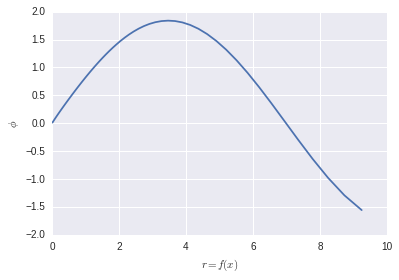

In [141]:
phi = c[1:-2].copy()
phi += np.concatenate([phi[1:], [0]])/4 + np.concatenate([[0], phi[:-1]])/4 
phi += c[-1]*P_c(f(xnet[:-1])) + c[-2]*P_s(f(xnet[:-1]))

plt.plot(f(xnet[:-1]), phi)
plt.xlabel('$r=f(x)$')
plt.ylabel('$\phi$')